In [4]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.autograd import Variable
from collections import Counter
import pickle as pkl
import random
import pdb
import re
from collections import Counter, defaultdict
from sklearn.model_selection import train_test_split

from nltk.tokenize import word_tokenize
import string
from nltk.corpus import stopwords

import matplotlib.pyplot as plt
from functools import partial

Get Data 

In [5]:
# load glove-embedding data
def load_emb_vectors(fname):
    data = {}
    with open(fname, 'r') as f:
        for line in f:
            splitLine = line.split()
            word = splitLine[0]
            embedding = np.array([float(val) for val in splitLine[1:]])
            data[word] = embedding
    return data
fname = '../data/glove.6B.50d.txt'
words_emb_dict = load_emb_vectors(fname)

In [25]:
# words_emb_dict['word']

In [8]:
# the data is the output of "Consolidated Data Cleaning"
data_all = pd.read_csv('../data/cleaned_recipe_data.csv', index_col=0)

In [9]:
data_all.columns

Index(['title', 'subtitle', 'carbs', 'fat', 'protein', 'chef_id', 'calories',
       'cooking_tips', 'story', 'ingredients_display', 'step_one', 'step_two',
       'step_three', 'step_four', 'step_five', 'step_six', 'recipe_tags',
       'tag_cuisine_african', 'tag_cuisine_mexican',
       'tag_cuisine_middle-eastern', 'tag_cuisine_latin-american',
       'tag_cuisine_french', 'tag_cuisine_italian', 'tag_cuisine_nordic',
       'tag_cuisine_american', 'tag_cuisine_asian',
       'tag_cuisine_mediterranean', 'tag_cuisine_indian',
       'tag_cuisine_european'],
      dtype='object')

In [10]:
data_intruction = data_all[['step_one','step_two', 'step_three', 'step_four', 'step_five', 'step_six']]

In [11]:
data_cuisine_tags = data_all[['tag_cuisine_indian', 'tag_cuisine_nordic', 'tag_cuisine_european',
       'tag_cuisine_asian', 'tag_cuisine_mexican',
       'tag_cuisine_latin-american', 'tag_cuisine_french',
       'tag_cuisine_italian', 'tag_cuisine_african',
       'tag_cuisine_mediterranean', 'tag_cuisine_american',
       'tag_cuisine_middle-eastern']]

In [12]:
data_intruction.step_one[1083]

'Preheat oven to 425°F. Pat chicken dry with paper towel and season all over with .5 teaspoon salt and black pepper as desired. Heat 1 tablespoon olive oil in a medium pan over medium-high heat. When oil is shimmering, add chicken and sear until cooked through and no longer pink, about 6 minutes per side. Transfer chicken to a plate or cutting board, and set aside to rest. Wipe pan clean and reserve for cooking salsa.'

Tokenization

In [13]:
# lowercase and remove punctuation
def tokenizer(sent):
    #print(sent)
    if pd.isnull(sent):
        words = []
    else:
        table = str.maketrans(string.punctuation, ' '*len(string.punctuation))
        sent = sent.translate(table)
        tokens = word_tokenize(sent)
        # convert to lower case
        tokens = [w.lower() for w in tokens]
        # remove punctuation from each word
        #table = str.maketrans('', '', string.punctuation)
        #stripped = [w.translate(table) for w in tokens]
        # remove remaining tokens that are not alphabetic
        words = [word for word in tokens if word.isalpha()]
        #re.findall(r'\d+', 'sdfa')
    return words

In [9]:
#re.findall(r'\d+', 'sdfa')

In [14]:
# 重新写，带上ID
def tokenize_dataset(step_n):
    """returns tokenization for each step, training set tokenizatoin"""
    token_dataset = []
    for sample in step_n:
        tokens = tokenizer(sample)
        token_dataset.append(tokens)
    return token_dataset

def all_tokens_list(train_data):
    """returns all tokens of instruction (all steps) for creating vocabulary"""
    all_tokens = []
    for columns in train_data.columns:
        for sample in train_data[columns]:
            all_tokens += sample[:]
    return all_tokens

In [15]:
# tokenize each steps
data_instruction_tokenized = pd.DataFrame()
for steps in data_intruction.columns:
    data_instruction_tokenized[steps] = tokenize_dataset(data_intruction[steps])
    print(steps, 'has been tokenized.')

step_one has been tokenized.
step_two has been tokenized.
step_three has been tokenized.
step_four has been tokenized.
step_five has been tokenized.
step_six has been tokenized.


In [16]:
data_instruction_tokenized.head()

,step_one,step_two,step_three,step_four,step_five,step_six
0,"[preheat, oven, to, place, butter, in, a, smal...","[on, a, baking, sheet, toss, carrots, green, b...","[while, vegetables, roast, mince, garlic, and,...","[pat, steaks, dry, with, paper, towel, and, se...","[once, roasted, remove, vegetables, from, oven...","[once, steaks, have, rested, find, the, direct..."
1,"[in, a, small, pot, combine, rice, cups, water...","[rinse, bell, pepper, and, halve, lengthwise, ...","[pat, steaks, dry, with, paper, towel, and, se...","[while, steaks, sear, heat, teaspoons, canola,...","[return, pan, from, steaks, to, medium, heat, ...","[once, rested, cut, steaks, against, the, grai..."
2,"[in, a, small, pot, combine, rice, cups, water...","[while, rice, cooks, halve, bok, choy, lengthw...","[heat, sesame, oil, in, a, medium, nonstick, p...","[add, cooked, rice, and, tablespoon, canola, o...","[pat, pork, chops, dry, with, a, paper, towel,...","[once, rested, cut, pork, into, inch, slices, ..."
3,"[preheat, oven, to, in, a, small, pot, combine...","[rinse, all, produce, halve, cucumber, lengthw...","[on, half, of, baking, sheet, toss, chickpeas,...","[while, chickpeas, and, tomatoes, roast, place...","[while, feta, bakes, in, a, large, bowl, whisk...","[divide, quinoa, between, serving, bowls, then..."
4,"[preheat, oven, to, pat, chicken, dry, with, p...","[while, chicken, cooks, halve, lime, cut, half...","[return, pan, from, chicken, to, medium, high,...","[stack, tortillas, wrap, in, foil, and, place,...","[stir, chipotle, paste, and, teaspoon, salt, i...","[divide, warmed, tortillas, between, serving, ..."


In [17]:
assert (data_instruction_tokenized.shape[0] == data_cuisine_tags.shape[0])

Split train, validation, test sets

In [18]:
RANDOM_STATE = 42
X_train, test_data, y_train, test_tags = train_test_split(data_instruction_tokenized, data_cuisine_tags, test_size=0.1, random_state=RANDOM_STATE)
train_data, val_data, train_tags, val_tags = train_test_split(X_train, y_train, test_size=0.1, random_state=RANDOM_STATE)

 All tokens from training set

In [19]:
# form all tokens list
all_train_tokens = all_tokens_list(train_data)

Let's decide which tag to predict for trail

In [20]:
data_cuisine_tags.sum()/data_cuisine_tags.shape[0]

tag_cuisine_indian            0.023525
tag_cuisine_nordic            0.000399
tag_cuisine_european          0.012360
tag_cuisine_asian             0.182217
tag_cuisine_mexican           0.013557
tag_cuisine_latin-american    0.094896
tag_cuisine_french            0.077352
tag_cuisine_italian           0.233254
tag_cuisine_african           0.003987
tag_cuisine_mediterranean     0.076555
tag_cuisine_american          0.273525
tag_cuisine_middle-eastern    0.046252
dtype: float64

Choose tag: tag_cuisine_american, which 27.3525% are 1 

Build vocabulary and indexing 

In [21]:
len(list(set(all_train_tokens)))

3191

In [22]:
token_counter = Counter(all_train_tokens)

In [19]:
# token_counter.most_common

In [23]:
# save index 0 for unk and 1 for pad
def build_vocab(all_tokens, max_vocab_size):
    # Returns:
    # id2token: list of tokens, where id2token[i] returns token that corresponds to token i
    # token2id: dictionary where keys represent tokens and corresponding values represent indices
    PAD_IDX = 0
    UNK_IDX = 1
    token_counter = Counter(all_tokens)
    vocab, count = zip(*token_counter.most_common(max_vocab_size))
    id2token = list(vocab)
    token2id = dict(zip(vocab, range(2,2+len(vocab)))) 
    id2token = ['<pad>', '<unk>'] + id2token
    token2id['<pad>'] = PAD_IDX 
    token2id['<unk>'] = UNK_IDX
    return token2id, id2token

In [24]:
max_vocab_size = len(list(set(all_train_tokens)))
token2id, id2token = build_vocab(all_train_tokens, max_vocab_size)

random_token_id = random.randint(0, len(id2token)-1)
random_token = id2token[random_token_id]

print("Token id {} ; token {}".format(random_token_id, id2token[random_token_id]))
print("Token {}; token id {}".format(random_token, token2id[random_token]))

Token id 1089 ; token strainer
Token strainer; token id 1089


In [26]:
def build_emb_weight(words_emb_dict, id2token):
    vocab_size = len(id2token)
    emb_dim = len(words_emb_dict['a'])
    emb_weight = np.zeros([vocab_size, emb_dim])
    for i in range(2,vocab_size):
        emb = words_emb_dict.get(id2token[i], None)
        if emb is not None:
            emb_weight[i] = emb
    return emb_weight

emb_weight = build_emb_weight(words_emb_dict, id2token)

# dump data about vocab and embedding
# pkl.dump(token2id, open("hw2_data/token2id.p", "wb"))
# pkl.dump(id2token, open("hw2_data/id2token.p", "wb"))
# pkl.dump(emb_weight, open("hw2_data/embedding_weight.p", "wb"))

Reconstruct data strcuture for datasets

In [27]:
# convert token to id in the dataset
def token2index_dataset(tokens_data, token2id):
    """returns [[[step1 indices],[step2 indices],...,[step6 indices]],[],[],...]"""
    recipie_indices_data = []
    UNK_IDX = 1
    for recipie in tokens_data.iterrows():
        step_indices_data = []
        for step in recipie[1]:
            index_list = [token2id[token] if token in token2id else UNK_IDX for token in step]
            step_indices_data.append(index_list)
        recipie_indices_data.append(step_indices_data)
    return recipie_indices_data

train_data_indices = token2index_dataset(train_data, token2id)
val_data_indices = token2index_dataset(val_data, token2id)
test_data_indices = token2index_dataset(test_data, token2id)

# double checking
print ("Train dataset size is {}".format(len(train_data_indices)))
print ("Val dataset size is {}".format(len(val_data_indices)))
print ("Test dataset size is {}".format(len(test_data_indices)))

Train dataset size is 2031
Val dataset size is 226
Test dataset size is 251


In [62]:
class IntructionDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """
    
    def __init__(self, data_list, tags_list, max_sent_len):
        """
        
        @param data_list: list of recipie tokens 
        @param target_list: list of single tag, i.e. 'tag_cuisine_american'

        """
        self.data_list = data_list
        self.tags_list = tags_list
        assert (len(self.data_list) == len(self.tags_list))

    def __len__(self):
        return len(self.data_list)
        
    def __getitem__(self, key):
        """
        Triggered when you call recipie[i]
        """
        recipie = self.data_list[key]
        step1_idx = recipie[0][:max_sent_len[0]]
        step2_idx = recipie[1][:max_sent_len[1]]
        step3_idx = recipie[2][:max_sent_len[2]]
        step4_idx = recipie[3][:max_sent_len[3]]       
        step5_idx = recipie[4][:max_sent_len[4]]
        step6_idx = recipie[5][:max_sent_len[5]]
        label = self.tags_list[key]
        return [[step1_idx, step2_idx, step3_idx, step4_idx, step5_idx, step6_idx], 
                [len(step1_idx),len(step2_idx), len(step3_idx),len(step4_idx), len(step5_idx),len(step6_idx)], 
                label]

def collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all 
    data have the same length
    """
    steps_dict = defaultdict(list)
    label_list = []
    length_dict = defaultdict(list)
    max_sent_len = []
    for datum in batch:
        label_list.append(datum[-1])
        for i in range(6):
            length_dict[i].append(datum[1][i])
    # padding
    for i in range(6):
        max_sent_len.append(max(length_dict[i]))
    
    for datum in batch:
        for i, step in enumerate(datum[0]):
            padded_vec = np.pad(np.array(step), 
                                pad_width=((0, max_sent_len[i]-datum[1][i])), 
                                mode="constant", constant_values=0)
            steps_dict[i].append(padded_vec)
    
    for key in length_dict.keys():
        length_dict[key] = torch.LongTensor(length_dict[key])
        steps_dict[key] = torch.from_numpy(np.array(steps_dict[key]).astype(np.int)) 
        
    return [steps_dict, length_dict, torch.LongTensor(label_list)]

In [61]:
# Build train, valid and test dataloaders
def create_dataset_obj(train,val,test,train_targets,val_targets,test_targets,
                       BATCH_SIZE,max_sent_len,collate_func):
    collate_func=partial(collate_func)
    train_dataset = IntructionDataset(train, train_targets, max_sent_len)
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                               batch_size=BATCH_SIZE,
                                               collate_fn=collate_func,
                                               shuffle=True)

    val_dataset = IntructionDataset(val, val_targets, max_sent_len)
    val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                               batch_size=BATCH_SIZE,
                                               collate_fn=collate_func,
                                               shuffle=False)

    test_dataset = IntructionDataset(test, test_targets, max_sent_len)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                               batch_size=BATCH_SIZE,
                                               collate_fn=collate_func,
                                               shuffle=False)
    return train_loader, val_loader, test_loader

In [31]:
train_targets = list(train_tags['tag_cuisine_american'])
val_targets = list(val_tags['tag_cuisine_american'])
test_targets = list(test_tags['tag_cuisine_american'])

In [100]:
def create_emb_layer(weights_matrix, trainable=False):
    vocab_size, emb_dim = weights_matrix.size()
    emb_layer = nn.Embedding(vocab_size, emb_dim)
    emb_layer.load_state_dict({'weight': weights_matrix})
    if trainable == False:
        emb_layer.weight.requires_grad = False
    return emb_layer, vocab_size, emb_dim

class two_stage_RNN(nn.Module):
    def __init__(self, rnn_1, hidden_dim1, bi, rnn_2, hidden_dim2, batch_size, cuda_on, num_classes):
        
        super(two_stage_RNN, self).__init__()
        
        self.hidden_dim1 = hidden_dim1
        self.hidden_dim2 = hidden_dim2

        self.embedding, vocab_size, emb_dim = create_emb_layer(weights_matrix, trainable=False)
        
        # module for steps in the fisrt stage
#         self.hidden_stage1, self.hidden_stage2 = self.init_hidden(batch_size, cuda_on)
        rnn_common = rnn_1(emb_dim, hidden_dim1, num_layers=1, 
                           batch_first=True, bidirectional=bi)
        self.rnn_each_step = nn.ModuleList([])
        for i in range(6):
            self.rnn_each_step.append(rnn_common)
        
        
        # module for the second stage
        self.steps_rnn = rnn_2(hidden_dim1, hidden_dim2, num_layers=1, batch_first=False)
        
        # module for interaction
        self.linear = nn.Linear(hidden_dim2, num_classes)
        
#     def init_hidden(self, batch_size, cuda_on):
#         # Function initializes the activation of recurrent neural net at timestep 0
#         # Needs to be in format (num_layers, batch_size, hidden_size)
#         hidden_stage1 = {}
#         for i in range(6):
#             hidden_stage1[str(i)] = Variable(torch.zeros(1, batch_size, self.hidden_dim1), 
#                                              requires_grad=True)
#         hidden_stage2 = Variable(torch.zeros(1, batch_size, self.hidden_dim2), 
#                                  requires_grad=True)
#         if torch.cuda.is_available() and cuda_on:
#             for i in range(6):
#                 hidden_stage1[str(i)] = hidden_stage1[str(i)].cuda()
#             hidden_stage2 = hidden_stage2.cuda()
        
#         return hidden_stage1, hidden_stage2

    def forward(self, steps, lengths):
        # first stage
        output_each_step = []
        for i in range(6):
            #print('1', steps[str(i)].size())
            rnn_input = steps[i]
            emb = self.embedding(rnn_input) # embedding
            #print('2', emb.size())
            #(torch.ones(emb.size(0))*torch.max(lengths[str(i)])).numpy()
            #emb = nn.utils.rnn.pack_padded_sequence(emb, np.array([80,]*10), batch_first=True)
            #print('3', emb.size())
            #torch.ones(emb.size(0))*step[i][1]
            output, _ = self.rnn_each_step[i](emb) #, self.hidden_stage1[str(i)]
            #print('3', output.size())
            # undo packing
            #output, _ = torch.nn.utils.rnn.pad_packed_sequence(output, batch_first=True)
            output_each_step.append(output[:,-1,:])
            #print('4', output_each_step[-1].size())
        
        #second stage
        output1 = torch.stack(output_each_step, 0)
        #print('5', output1.size())
        output, _ = self.steps_rnn(output1) #, self.hidden_stage2
        logits = self.linear(output[-1,:,:])
        logits = torch.sigmoid(logits)
        return logits

from sklearn.metrics import roc_auc_score
def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    logits_all = []
    labels_all = []
    model.eval()
    for steps_batch, lengths_batch, labels_batch in loader:
        for step_id in range(6):
            lengths_batch[step_id] = lengths_batch[step_id].cuda()
            steps_batch[step_id] = steps_batch[step_id].cuda() 
        logits = model(steps_batch, lengths_batch)
        logits_all.extend(list(logits.cpu().detach().numpy()))
        labels_all.extend(list(labels_batch.numpy()))
    logits_all = np.array(logits_all)
    labels_all = np.array(labels_all)
    auc = roc_auc_score(labels_all, logits_all)
    predicts = (logits_all > 0.5).astype(int)
    acc = np.mean(predicts==labels_all)
    return auc, acc

In [155]:
rnn_types = {
    'rnn': nn.RNN,
    'lstm': nn.LSTM,
    'gru': nn.GRU
}

params = dict(
    rnn1_type = 'gru',
    rnn2_type = 'gru',
    bi = False,
    hidden_dim1 = 30,
    hidden_dim2 = 30,
    num_classes = 1,
    
    num_epochs = 10,
    batch_size = 50,
    learning_rate = 0.01,
    cuda_on = True 
)

In [104]:
BATCH_SIZE = params['batch_size']
max_sent_len = np.array([94, 86, 87, 90, 98, 91])

train_loader, val_loader, test_loader = create_dataset_obj(train_data_indices, val_data_indices,
                                                           test_data_indices, train_targets,
                                                           val_targets, test_targets,
                                                           BATCH_SIZE, max_sent_len, 
                                                           collate_func)

In [156]:
# build model
rnn1_type = params['rnn1_type'] 
rnn_1 = rnn_types[rnn1_type]
rnn2_type = params['rnn2_type']
rnn_2 = rnn_types[rnn2_type]
bi = params['bi']
hidden_dim1 = params['hidden_dim1']
hidden_dim2 = params['hidden_dim2']
num_classes = params['num_classes']
batch_size = params['batch_size']
cuda_on = params['cuda_on']

weights_matrix = torch.from_numpy(emb_weight)
model = two_stage_RNN(rnn_1, hidden_dim1, bi, rnn_2, hidden_dim2, batch_size, cuda_on, num_classes)
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
print('The number of train parameters', sum([np.prod(p.size()) for p in model_parameters]))
model = model.cuda()

#parameter for training
learning_rate = params['learning_rate']
num_epochs = params['num_epochs'] # number epoch to train

# Criterion and Optimizer
criterion = torch.nn.BCELoss() #torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_loss_list = []

for epoch in range(num_epochs):
    for i, (steps_batch, lengths_batch, labels_batch) in enumerate(train_loader):
        for step_id in range(6):
            lengths_batch[step_id] = lengths_batch[step_id].cuda()
            steps_batch[step_id] = steps_batch[step_id].cuda() 
        model.train()
        optimizer.zero_grad()
        outputs = model(steps_batch, lengths_batch)
        loss = criterion(outputs, labels_batch.view(-1,1).float().cuda()) 
        train_loss_list.append(loss.item())
        loss.backward()
        optimizer.step()
        # validate every 100 iterations
        if i % 10 == 0:
            # validate
#             print('---------------------')
#             for p in model.parameters():
#                 if p.requires_grad:
#                     print(p.name, p.size(), p.requires_grad, torch.mean(torch.abs(p.data)), torch.mean(torch.abs(p.grad)))
#                     break
            val_auc, val_acc = test_model(val_loader, model)
            print('{}/{}, Step:{}/{}, TrainLoss:{:.6f}, ValAUC:{:.6f} ValAcc:{:.6f}'.format(
                epoch+1, num_epochs, i+1, len(train_loader), loss, val_auc, val_acc))
    val_auc, val_acc = test_model(val_loader, model)
    train_auc, train_acc = test_model(train_loader, model)
    print('Epoch: [{}/{}], trainAUC: {:.6f}, trainAcc: {:.6f}'.format(epoch+1, num_epochs, train_auc, train_acc))
    print('Epoch: [{}/{}], ValAUC: {:.6f}, ValAcc: {:.6f}'.format(epoch+1, num_epochs, val_auc, val_acc))


The number of train parameters 12991
1/10, Step:1/41, TrainLoss:0.672168, ValAUC:0.516975 ValAcc:0.774336
1/10, Step:11/41, TrainLoss:0.592580, ValAUC:0.459776 ValAcc:0.774336
1/10, Step:21/41, TrainLoss:0.650044, ValAUC:0.397031 ValAcc:0.774336
1/10, Step:31/41, TrainLoss:0.790996, ValAUC:0.445098 ValAcc:0.771909
1/10, Step:41/41, TrainLoss:0.562809, ValAUC:0.483866 ValAcc:0.774336
Epoch: [1/10], trainAUC: 0.566269, trainAcc: 0.720392
Epoch: [1/10], ValAUC: 0.483866, ValAcc: 0.774336
2/10, Step:1/41, TrainLoss:0.624023, ValAUC:0.483585 ValAcc:0.774336
2/10, Step:11/41, TrainLoss:0.707214, ValAUC:0.495742 ValAcc:0.774336
2/10, Step:21/41, TrainLoss:0.602230, ValAUC:0.618375 ValAcc:0.774336
2/10, Step:31/41, TrainLoss:0.477226, ValAUC:0.549524 ValAcc:0.774336
2/10, Step:41/41, TrainLoss:0.627741, ValAUC:0.561120 ValAcc:0.771909
Epoch: [2/10], trainAUC: 0.549760, trainAcc: 0.719740
Epoch: [2/10], ValAUC: 0.561120, ValAcc: 0.771909
3/10, Step:1/41, TrainLoss:0.551893, ValAUC:0.574454 ValA

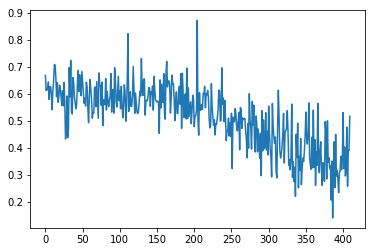

In [137]:
plt.plot(train_loss_list)

In [87]:
train_loss_list

[0.6757375001907349,
 0.5646308064460754,
 0.64335697889328,
 0.2568894326686859,
 0.7615655660629272,
 0.9333148002624512,
 0.6498864889144897,
 0.4107288420200348,
 0.6134276390075684,
 0.6030378341674805,
 0.5463663339614868,
 0.7387714385986328,
 0.5065492987632751,
 0.5752663016319275,
 0.6463063955307007,
 0.5616048574447632,
 0.5865553617477417,
 0.5765119791030884,
 0.44994696974754333,
 0.44220060110092163,
 0.5501409769058228,
 0.4910675883293152,
 0.8408665657043457,
 0.7500380277633667,
 0.8029074668884277,
 1.1556341648101807,
 0.522466778755188,
 0.6046282052993774,
 0.823531448841095,
 0.6150627136230469,
 0.5091487169265747,
 0.610922634601593,
 0.5316156148910522,
 0.615510106086731,
 0.5314379930496216,
 0.6279920339584351,
 0.6088553667068481,
 0.5636845231056213,
 0.6771212220191956,
 0.6259201169013977,
 0.4877234995365143,
 0.5430082082748413,
 0.5322695970535278,
 0.7806535959243774,
 0.6980239748954773,
 0.4372164309024811,
 0.6175408363342285,
 0.51453387737274

In [151]:
print(model)

two_stage_RNN(
  (embedding): Embedding(3193, 50)
  (rnn_each_step): ModuleList(
    (0): RNN(50, 50, batch_first=True)
    (1): RNN(50, 50, batch_first=True)
    (2): RNN(50, 50, batch_first=True)
    (3): RNN(50, 50, batch_first=True)
    (4): RNN(50, 50, batch_first=True)
    (5): RNN(50, 50, batch_first=True)
  )
  (steps_rnn): RNN(50, 50)
  (linear): Linear(in_features=50, out_features=1, bias=True)
)


In [98]:
for key, val in model.state_dict().items():
    print(key, val.size())

embedding.weight torch.Size([3193, 50])
rnn_each_step.0.weight_ih_l0 torch.Size([150, 50])
rnn_each_step.0.weight_hh_l0 torch.Size([150, 50])
rnn_each_step.0.bias_ih_l0 torch.Size([150])
rnn_each_step.0.bias_hh_l0 torch.Size([150])
rnn_each_step.1.weight_ih_l0 torch.Size([150, 50])
rnn_each_step.1.weight_hh_l0 torch.Size([150, 50])
rnn_each_step.1.bias_ih_l0 torch.Size([150])
rnn_each_step.1.bias_hh_l0 torch.Size([150])
rnn_each_step.2.weight_ih_l0 torch.Size([150, 50])
rnn_each_step.2.weight_hh_l0 torch.Size([150, 50])
rnn_each_step.2.bias_ih_l0 torch.Size([150])
rnn_each_step.2.bias_hh_l0 torch.Size([150])
rnn_each_step.3.weight_ih_l0 torch.Size([150, 50])
rnn_each_step.3.weight_hh_l0 torch.Size([150, 50])
rnn_each_step.3.bias_ih_l0 torch.Size([150])
rnn_each_step.3.bias_hh_l0 torch.Size([150])
rnn_each_step.4.weight_ih_l0 torch.Size([150, 50])
rnn_each_step.4.weight_hh_l0 torch.Size([150, 50])
rnn_each_step.4.bias_ih_l0 torch.Size([150])
rnn_each_step.4.bias_hh_l0 torch.Size([150])


In [152]:
logits_all = []
labels_all = []
model.eval()
for steps_batch, lengths_batch, labels_batch in test_loader:
    for step_id in range(6):
        lengths_batch[step_id] = lengths_batch[step_id].cuda()
        steps_batch[step_id] = steps_batch[step_id].cuda() 
    logits = model(steps_batch, lengths_batch)
    logits_all.extend(list(logits.cpu().detach().numpy()))
    labels_all.extend(list(labels_batch.numpy()))
logits_all = np.array(logits_all)
labels_all = np.array(labels_all)
auc = roc_auc_score(labels_all, logits_all)
predicts = (logits_all > 0.5).astype(int)
acc = np.mean(predicts==labels_all)

In [153]:
auc

0.56858727097396344

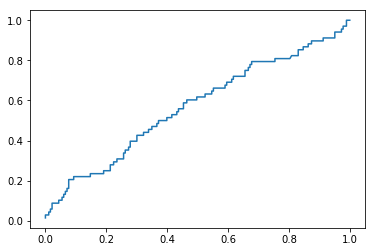

In [154]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(labels_all, logits_all, pos_label=1)
plt.plot(fpr, tpr)

In [115]:
for item in zip(labels_all,logits_all):
    print(item)

(0, array([ 0.34820956], dtype=float32))
(0, array([ 0.7578283], dtype=float32))
(0, array([ 0.22247064], dtype=float32))
(0, array([ 0.43045336], dtype=float32))
(0, array([ 0.48476711], dtype=float32))
(0, array([ 0.77117282], dtype=float32))
(1, array([ 0.80068904], dtype=float32))
(0, array([ 0.04711582], dtype=float32))
(0, array([ 0.11268219], dtype=float32))
(1, array([ 0.32941702], dtype=float32))
(1, array([ 0.5870285], dtype=float32))
(0, array([ 0.327185], dtype=float32))
(0, array([ 0.83897358], dtype=float32))
(1, array([ 0.41926068], dtype=float32))
(0, array([ 0.39112851], dtype=float32))
(0, array([ 0.09330124], dtype=float32))
(1, array([ 0.58193177], dtype=float32))
(1, array([ 0.44127423], dtype=float32))
(1, array([ 0.17955196], dtype=float32))
(1, array([ 0.38827571], dtype=float32))
(0, array([ 0.73819947], dtype=float32))
(0, array([ 0.14464475], dtype=float32))
(1, array([ 0.52704066], dtype=float32))
(1, array([ 0.09829863], dtype=float32))
(0, array([ 0.579515